<a href="https://colab.research.google.com/github/coolmich0904/YouTube_Family_Plan_Policy_Chang_Impact_Analysis/blob/main/Youtube_Family_Plan_Policy_Change.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Task: Install required libraries for data collection into the local directory
# Reference: Industry benchmark from Netflix (15-30% churn intent)
# Hypothesis: Youtube's integration with Youtube Music might lead to a 40% impact for non-complaint users

!pip install yfinance faker pandas numpy pytrends

import pandas as pd
import numpy as np
import yfinance as yf
import random
import seaborn as sns
import matplotlib.pyplot as plt
from faker import Faker


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 12.4 MB/s eta 0:00:00


In [2]:

faker= Faker()

# Generate raw data focusing on Family Plan issues
def generate_youtube_raw_data(n=1000):
    data=[]
    flag_date = pd.to_datetime('2025-09-01')

    for _ in range(n):
        # Assign Random Action Date within 2025
        action_date = faker.date_between(start_date='-1y', end_date='today')
        is_after_flag = pd.to_datetime(action_date) >= flag_date

        # Users after flag_date face 'Address Verification'
        if is_after_flag:
            # 40% churn hy[othesis based on the Netflix benchmark reference
            status = np.random.choice(['Cancelled', 'Active'], p=[0.4, 0.6])

            # If cancelled, dud they stay or leave??
            if status == 'Cancelled':
                outcome = np.random.choice(['Switch to Individual', 'Complete Exit'], p=[0.7, 0.3])
            else:
                outcome = 'N/A'

            data.append({
                'user_id': faker.uuid4(),
                'action_date': action_date,
                'is_after_flag': is_after_flag,
                'status': status,
                'final_outcome': outcome
            })
    return pd.DataFrame(data)

# Convert the date objects to strings to prevent JSON from turning them into numbers
youtube_df = generate_youtube_raw_data(1200)
youtube_df['action_date'] = youtube_df['action_date'].astype(str)

# Save to JSON
youtube_df.to_json('youtube_churn_analysis_raw.json', orient='records', indent=4)

print("Success: youtube_churn_analysis_raw.json generated with YouTube-only context.")


Success: youtube_churn_analysis_raw.json generated with YouTube-only context.


In [3]:
# Task: Clean Raw Youtube Churn Data for Azure AI Modeling

# Convert date string to datetime objects
# Map categorical data to numerical values for better analysis

# Load Generated JSON file
raw_data = pd.read_json('youtube_churn_analysis_raw.json')

# 1. Transform timestamp
raw_data['action_date'] = pd.to_datetime(raw_data['action_date'], errors='coerce')

# 2. Handle 'N/A' values in final_outcome
raw_data['final_outcome'] = raw_data['final_outcome'].replace('N/A', 'Stayed')

# 3. Numeric flag for churn (1 for cancelled, 0 for Active)
raw_data['is_churned'] = raw_data['status'].apply(lambda x: 1 if x == 'Cancelled' else 0)

# Preview the cleaned Data
print(raw_data.info())
print(raw_data.head())

# Save the cleaned version
raw_data.to_csv('youtube_churn_cleaned_data.csv', index=False)
print("\nSaved Successfully")


,user_id,action_date,is_after_flag,status,final_outcome
0,b501cb3a-7c9f-4ddd-8ca8-8ba51d1d950d,2025-12-17,True,Active,N/A
1,d6913ffe-2883-4d0d-ad3d-d6f90b31dbf9,2025-09-02,True,Cancelled,Switch to Individual
2,b050ecbf-5185-4e61-bed8-5e896bddddd2,2025-10-04,True,Active,N/A
3,7ddcd0b2-51fc-4d2e-9f08-02a39f6a13c9,2025-10-02,True,Active,N/A
4,5a1db5cb-89c3-465a-bda9-8724b0fd7a3f,2025-12-14,True,Active,N/A


In [ ]:
# Now find the rate for is_churned == 1
churned_df = raw_data[raw_data['is_churned'] == 1]
churned_df.head()

,user_id,action_date,is_after_flag,status,final_outcome,is_churned
0,95607efe-7147-4558-b587-b35d3a3c4e20,2025-11-19,True,Cancelled,Switch to Individual,1
1,704b34c8-ef84-47b0-8408-e5f9e66d5056,2025-11-29,True,Cancelled,Complete Exit,1
6,f984e961-1d26-4471-853b-eaa6f05deaa7,2025-11-22,True,Cancelled,Switch to Individual,1
7,ccdb7598-d980-4341-b295-14dde57726b2,2025-09-02,True,Cancelled,Complete Exit,1
15,e07e8f62-8deb-4f05-b1e7-613f577a041c,2025-12-06,True,Cancelled,Switch to Individual,1


In [ ]:
# find the conversion rate for tranferring to the individual fare among the cancled people
conversion_rate = (len(churned_df[churned_df['final_outcome'] == 'Switch to Individual']) / len(churned_df)) * 100
print (f"Conversion Rate to Individual fare: {conversion_rate:.2f}%")

Conversion Rate to Individual fare: 70.98%


In [ ]:
# Find complete exit rate
comp_churned = len(churned_df)
comp_exit_count = len(churned_df[churned_df['final_outcome'] == 'Complete Exit'])
exit_rate = (comp_exit_count / len(churned_df)) * 100

print(f"Total Churned: {len(churned_df)}")
print(f"Complete Exit Rate: {exit_rate: .2f}%")

Total Churned: 193
Complete Exit Rate:  29.02%


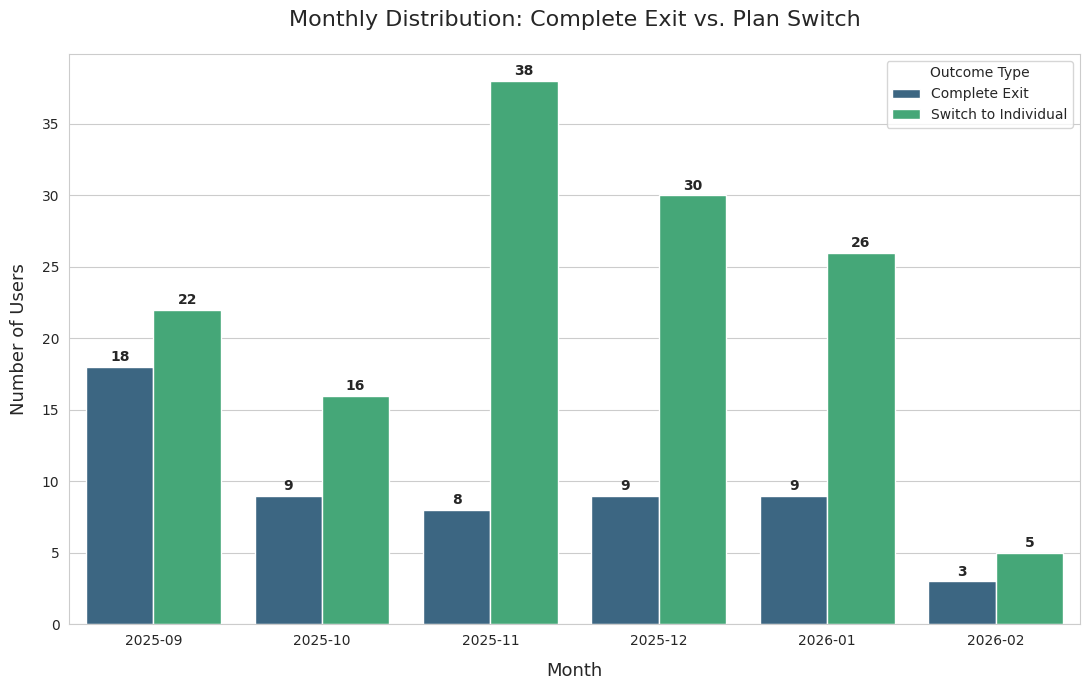

In [ ]:
#  Set Visual Style
sns.set_style("whitegrid")

# --- Explicit Copy (The Easiest Way) ---
# Add .copy() at the end to create a standalone DataFrame
churned_df = raw_data[raw_data['status'] == 'Cancelled'].copy()


# Preprocess DATE type
churned_df['action_date'] = pd.to_datetime(churned_df['action_date'])

# Number of users by monthly data
churned_df['month'] =  churned_df['action_date'].dt.strftime('%Y-%m')

monthly_counts = churned_df.groupby(['month', 'final_outcome']).size().reset_index(name='count')

#  Bar Chart : Churn outcome distribution
plt.figure(figsize=(11, 7))
ax = sns.barplot(data=monthly_counts, x='month', y='count', hue='final_outcome', palette='viridis')


# Labeling - Add data labels on top of bars
for p in ax.patches:
    if p.get_height() > 0:
      ax.annotate(f'{int(p.get_height())}', (p.get_x()  + p.get_width() / 2., p.get_height()),
                  ha='center', va='center', xytext=(0, 7), textcoords='offset points', fontweight='bold')

# Title, Labels
plt.title('Monthly Distribution: Complete Exit vs. Plan Switch', fontsize=16, pad=20)
plt.xlabel('Month', fontsize=13, labelpad=10)
plt.ylabel('Number of Users', fontsize=13, labelpad=10)
plt.legend(title='Outcome Type')

plt.tight_layout()
plt.savefig('monthly_churn_outcome.png', dpi=300)
plt.show()





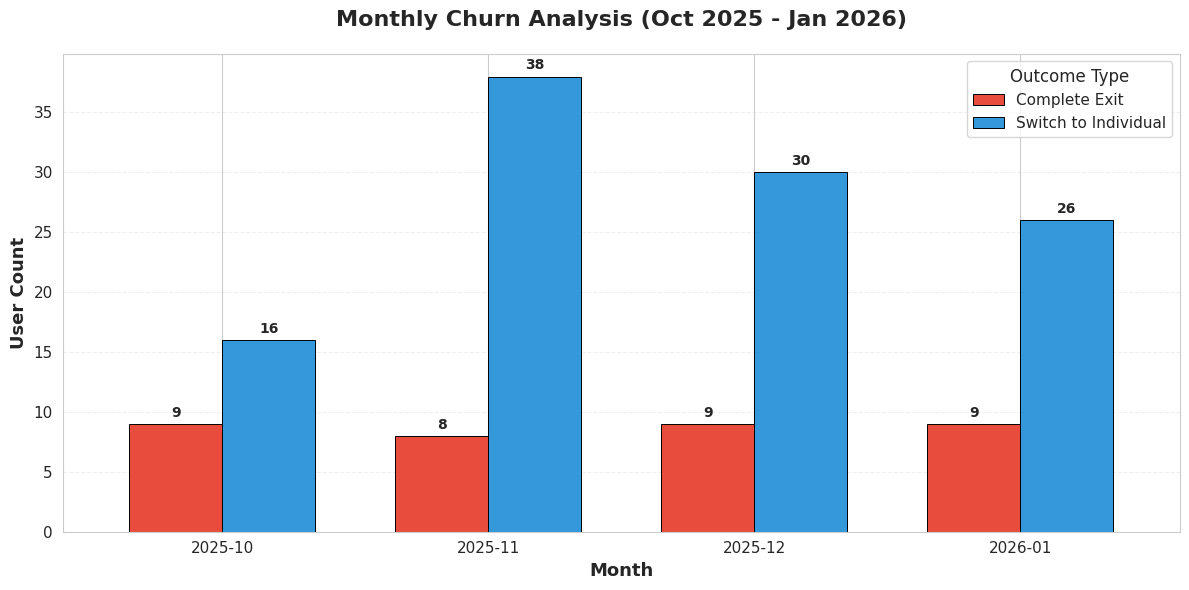


=== Monthly Churn Summary ===
final_outcome  Complete Exit  Switch to Individual
month                                             
2025-10                    9                    16
2025-11                    8                    38
2025-12                    9                    30
2026-01                    9                    26

Total churned users: 145


In [ ]:
# Load data
df = pd.read_csv('youtube_churn_cleaned_data.csv')

# "YYYY-MM-DD"
df['action_date'] = pd.to_datetime(df['action_date'], errors='coerce')

# Filter for churned users only (is_churned = 1)
churned_df = df[df['is_churned'] == 1].copy()

# Create month column
churned_df['month'] = churned_df['action_date'].dt.strftime('%Y-%m')

# Filter for the period shown in your image (2025-10 to 2026-01)
churned_df = churned_df[
    (churned_df['action_date'] >= '2025-10-01') &
    (churned_df['action_date'] <= '2026-01-31')
]

# Group by month and final_outcome
plot_table = churned_df.groupby(['month', 'final_outcome']).size().unstack(fill_value=0)

# Reorder columns if needed for better visualization
if 'Complete Exit' in plot_table.columns and 'Switch to Individual' in plot_table.columns:
    plot_table = plot_table[['Complete Exit', 'Switch to Individual']]

# Create bar chart
ax = plot_table.plot(
    kind='bar',
    figsize=(12, 6),
    width=0.7,
    color=['#E74C3C', '#3498DB'],
    edgecolor='black',
    linewidth=0.7
)

# Add data labels on bars
for container in ax.containers:
    ax.bar_label(container, fmt='%d', padding=3, fontweight='bold', fontsize=10)

# Formatting
plt.title('Monthly Churn Analysis (Oct 2025 - Jan 2026)', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Month', fontsize=13, fontweight='bold')
plt.ylabel('User Count', fontsize=13, fontweight='bold')
plt.xticks(rotation=0, fontsize=11)
plt.yticks(fontsize=11)
plt.legend(title='Outcome Type', fontsize=11, title_fontsize=12)
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()

# Save and show
plt.savefig('monthly_churn_outcome.png', dpi=300)
plt.show()

print("\n=== Monthly Churn Summary ===")
print(plot_table)
print(f"\nTotal churned users: {len(churned_df)}")

In [ ]:
# Task: Clean Raw Youtube Churn Data for Azure AI Modeling

# Convert date string to datetime objects
# Map categorical data to numerical values for better analysis

# Load Generated JSON file
raw_data = pd.read_json('youtube_churn_analysis_raw.json')

# Handle 'N/A' values in final_outcome
raw_data['final_outcome'] = raw_data['final_outcome'].replace('N/A', 'Stayed')

#  Numeric flag for churn (1 for cancelled, 0 for Active)
raw_data['is_churned'] = raw_data['status'].apply(lambda x: 1 if x == 'Cancelled' else 0)

# Preview the cleaned Data
print(raw_data.head())

# Save the cleaned version for Azure AI Foundry
raw_data.to_csv('youtube_churn_cleaned_data.csv', index=False)
print("\nSaved Successfully")


                                user_id action_date  is_after_flag     status  \
0  95607efe-7147-4558-b587-b35d3a3c4e20  2025-11-19           True  Cancelled   
1  704b34c8-ef84-47b0-8408-e5f9e66d5056  2025-11-29           True  Cancelled   
2  8d3cc877-c916-4868-9be1-1fdef544b45e  2025-11-03           True     Active   
3  387084c7-b22e-4ec5-89cb-cc41bc2a8a9b  2025-12-16           True     Active   
4  0183d188-58d0-4703-9d3d-6c78593d2ae3  2025-09-28           True     Active   

          final_outcome  is_churned  
0  Switch to Individual           1  
1         Complete Exit           1  
2                Stayed           0  
3                Stayed           0  
4                Stayed           0  

Saved Successfully


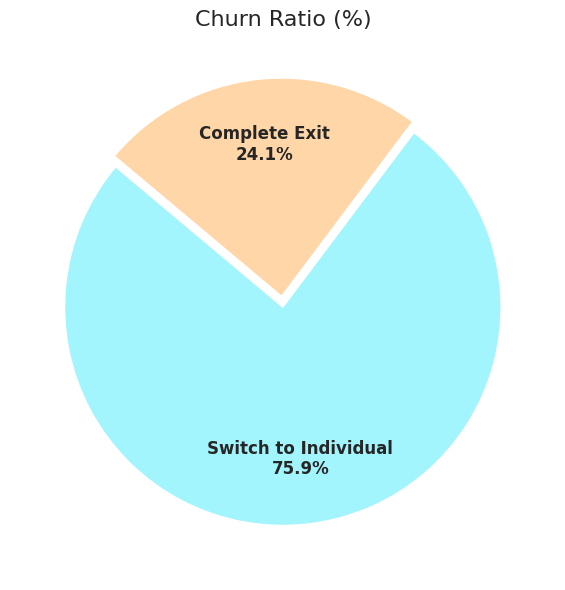

In [ ]:
from IPython.core.magics import auto
# Pie Chart : Churn Ratio
outcome_counts = churned_df['final_outcome'].value_counts()
labels=outcome_counts.index
values=outcome_counts.values

# Create a pie chart

plt.figure(figsize=(6, 6))

wedges, texts, autotexts = plt.pie(
        values,
        labels=None,
        autopct='%1.1f%%',
        startangle=140,
        colors=sns.color_palette(['#A2F4FD', '#FFD6A7']),
        explode=[0.05 if i == 'Complete Exit' else 0 for i in labels],
        pctdistance=0.7, # Adjusted to place percentage & Category name inside
        labeldistance=1.1,
        textprops={'fontsize':12, 'fontweight':'bold'})

# Label position
for i, (text, autotext) in enumerate(zip(texts, autotexts)):
  # combine label of outside and value of inside
  combined_text = f"{labels[i]}\n{autotext.get_text()}"

  autotext.set_text(combined_text)
  autotext.set_fontsize(12)


  # remove the label outside of pie
  text.set_text("")                                  #


plt.title('Churn Ratio (%)', fontsize=16)
plt.tight_layout()
plt.savefig('churn_ratio.png', dpi=300)
plt.show()

In [ ]:
# --- STEP: Final Data Export for Power BI & GitHub ---

import pandas as pd
from google.colab import files

# 1. Format date as a fixed string to prevent numeric conversion errors
# Use 'raw_data' or 'cleaned_data' based on your final variable name
df_final = raw_data.copy()

# Ensure the date column is formatted as YYYY-MM-DD
df_final['action_date'] = pd.to_datetime(df_final['action_date']).dt.strftime('%Y-%m-%d')

# 2. Define the output filename
export_filename = 'youtube_churn_final_report.csv'

# 3. Save to the Colab server environment
df_final.to_csv(export_filename, index=False)

# 4. Trigger the local browser download
print(f"Exporting {export_filename} to local storage...")
files.download(export_filename)

# 5. Quick validation check
print("Export Successful. Date Format Preview:")
print(df_final['action_date'].head())

Exporting youtube_churn_final_report.csv to local storage...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Export Successful. Date Format Preview:
0    2025-11-19
1    2025-11-29
2    2025-11-03
3    2025-12-16
4    2025-09-28
Name: action_date, dtype: object
